# **Capstone Project: [Deteksi Penyakit pada Tanaman Kelapa Sawit]**
**ID Group:** LAI25-RM112

**Anggota Kelompok:**
- A200YBF418_Refanda Surya Saputra - A200YBF418@devacademy.id
- A270YAF435_Risky Fahriza - A270YAF435@devacademy.id
- A528YBF449_Sebastian Luth Hasibuan - A528YBF449@devacademy.id
- A184YBF450_Sefza Auma Alam - A184YBF450@devacademy.id

## **Import Libraries/Packages**

In [81]:
import os
import random
import shutil
import warnings
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras import Model, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from skimage import io
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.transform import rotate, AffineTransform, warp
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm as tq

import gdown
from google.colab import drive

print(tf.__version__)

2.18.0


## **Loading Data**

### **Preparation Data**

Menggunakan dataset dari google drive pada google colab

In [13]:
# Mounting dari google drive
drive.mount('/content/drive')

# Mengakses dataset di google drive
dataset_path = '/content/drive/My Drive/Capstone LAI25-RM112/Dataset/palm-disease-dataset.zip'

# Ekstrak dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_file:
    zip_file.extractall('/content/dataset')

Mounted at /content/drive


Mengunduh dataset ke penyimpanan lokal

In [ ]:
# Ketika menggunakan IDE lokal
file_id = "1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, 'palm-disease-dataset.zip', quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4
From (redirected): https://drive.google.com/uc?id=1c9iWUpGHYl-eq057RheOT6q2-hcpj9F4&confirm=t&uuid=4c716aa7-8a38-4c83-9b1a-f0007b46edad
To: /home/refanzzzz/PycharmProjects/CP-Laskar-AI-LAI25-RM112/palm-disease-dataset.zip
100%|██████████| 779M/779M [02:49<00:00, 4.59MB/s] 


'palm-disease-dataset.zip'

In [ ]:
# Unzip berkas yang telah diuduh dari google drive
with zipfile.ZipFile('palm-disease-dataset.zip', 'r') as zip_file:
    zip_file.extractall()

### Checking Dataset

In [14]:
# Mengecek label pada dataset
palm_disease_path  = "dataset/palm-disease-dataset"

# Menyimpan label
list_label = os.listdir(palm_disease_path)

# Menampilkan list label
list_label

['Magnesium Deficiency', 'Healthy', 'Fungal Disease', 'Scale Insect']

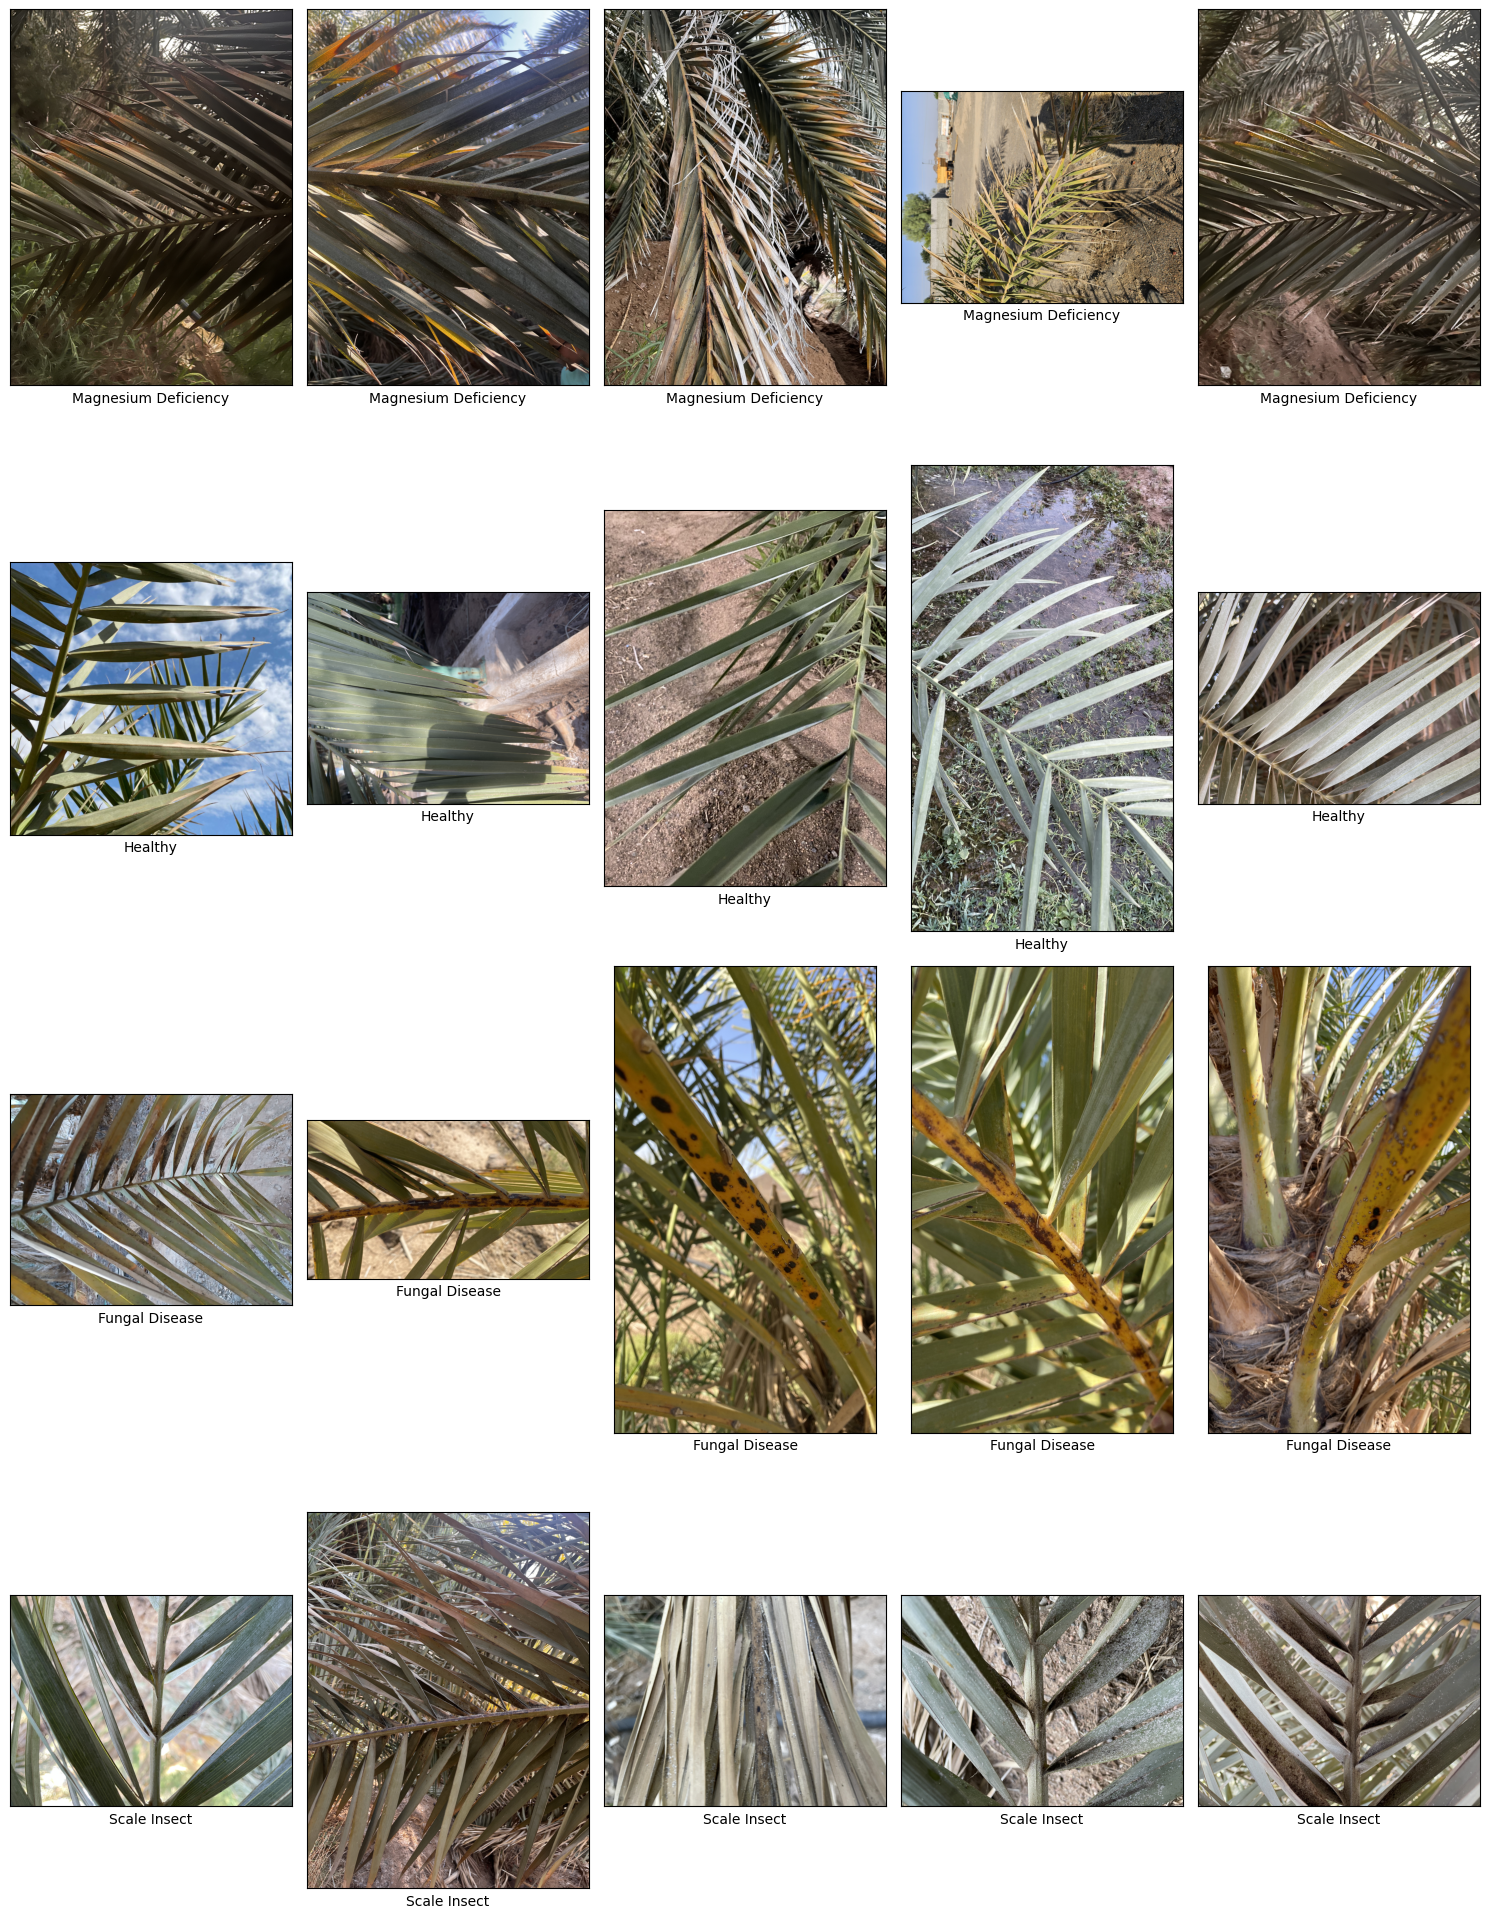

In [15]:
# Membuat dictionary untuk menyimpan gambar untuk setiap kelas dalam data
palm_disease_image = {}

# Menentukan path sumber dataset
source_path = "dataset/palm-disease-dataset/"

for i in os.listdir(source_path):
  palm_disease_image[i]  = os.listdir(source_path + i)

# menampilkan secara acak 5 gambar untuk masing-masing kelas
fig, ax = plt.subplots(4, 5, figsize=(15, 20))

for i, label in enumerate(os.listdir(source_path)):
  images = np.random.choice(palm_disease_image[label], 5, replace=False)
  for j, image in enumerate(images):
    img_path = os.path.join(source_path, label, image)
    img = Image.open(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set(xlabel=label, xticks=[], yticks=[])

fig.tight_layout()

In [16]:
# Membuat fungsi untuk melihat jumlah image tiap-tiap kelas
def get_image_count(path):
  image_count = {}
  for label in os.listdir(path):
    image_count[label] = len(os.listdir(os.path.join(path, label)))
  return image_count

print(get_image_count(source_path))

{'Magnesium Deficiency': 69, 'Healthy': 37, 'Fungal Disease': 53, 'Scale Insect': 80}


### Distribution Plot of Class Dataset

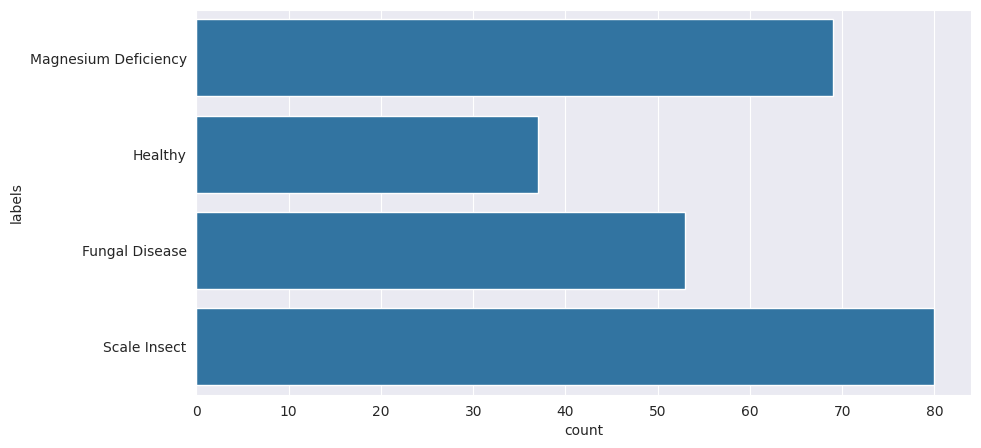

In [17]:
def plot_distribution(path):
  # Membuat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
  file_name = []
  labels = []
  full_path = []

  # Mendapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai DataFrame
  for path, subdirs, files in os.walk(path):
    for name in files:
      file_name.append(name)
      labels.append(path.split('/')[-1])
      full_path.append(os.path.join(path, name))

  distribution_train = pd.DataFrame({
      'path': full_path,
      'file_name': file_name,
      'labels': labels
  })

  # Plot distribusi gambar setiap kelas
  label = distribution_train['labels']
  plt.figure(figsize=(10, 5))
  sns.set_style('darkgrid')
  sns.countplot(label)

plot_distribution(source_path)

## Preprocessing Data

### Augmentation Data

In [18]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  angle = random.randint(0, 180)
  return rotate(img, angle)

# Membuat fungsi untuk melakukan rotasi searah jarum ram
def clockwise_rotation(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  angle = random.randint(0, 180)
  return rotate(img, -angle)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  img = adjust_gamma(img, gamma=0.5)
  return img

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  transform = AffineTransform(shear=0.2)
  shear_img = warp(img, transform, mode='wrap')
  return shear_img

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  transform = AffineTransform(translation=(0, 40))
  warp_img = warp(img, transform, mode='wrap')
  return warp_img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return cv2.GaussianBlur(img, (9, 9), 0)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return np.flipud(img)

# Membuat fungsi untuk membalik gambar secara horizontal dari kiri ke kanan
def flip_left_right(img):
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = cv2.resize(img, (224, 224))
  return np.fliplr(img)

In [46]:
# Membuat varabel transofrmasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {
    'anticlockwise_rotation': anticlockwise_rotation,
    'clockwise_rotation': clockwise_rotation,
    'add_brightness': add_brightness,
    'sheared': sheared,
    'warp_shift': warp_shift,
    'blur_image': blur_image,
    'flip_up_down': flip_up_down,
    'flip_left_right': flip_left_right
}

def generate_augmented_image(image_class_name, source_image_path, num_augmented_images):
  img_processed_path = os.path.join(source_image_path, image_class_name)

  processed_images = []

  for img in os.listdir(img_processed_path):
    processed_images.append(os.path.join(img_processed_path, img))

  images_to_generate = num_augmented_images - len(os.listdir(img_processed_path))

  i = 1

  while i <= images_to_generate:
    random_image = random.choice(processed_images)

    try:
      original_image = io.imread(random_image)
      transformed_image = None

      num_transformations_to_apply = random.randint(1, len(transformations))

      num_transformations = 0

      while num_transformations <= num_transformations_to_apply:
        key = random.choice(list(transformations))
        transformed_image = transformations[key](original_image)
        num_transformations += 1

      new_image_path = "%s/augmented_image_%s.jpg" % (img_processed_path, i)
      transformed_image = img_as_ubyte(transformed_image)
      cv2.imwrite(new_image_path, transformed_image)
      i += 1
    except Exception as e:
      print('Could not read the', image, ':', e, 'hence skipping it.')

In [47]:
for label in list_label:
  generate_augmented_image(label, source_path, 150)

Could not read the IMG_1116.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_64`` with iomode `r`. hence skipping it.
Could not read the IMG_1116.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_63`` with iomode `r`. hence skipping it.
Could not read the IMG_1116.JPG : Could not find a backend to open `dataset/palm-disease-dataset/Magnesium Deficiency/M6_63`` with iomode `r`. hence skipping it.


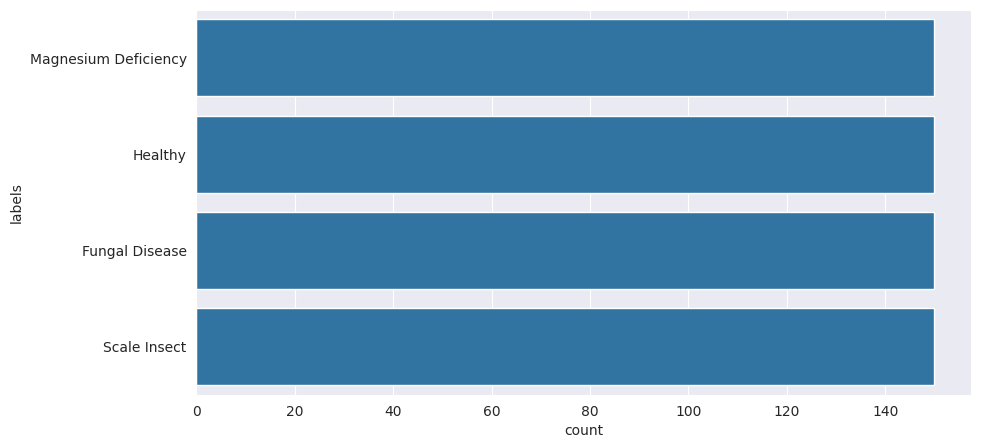

In [48]:
# Melihat plot distribusi kelas setelah dilakukan augmentasi
plot_distribution(source_path)

### Spliting Data

In [49]:
# Membuat variabel untuk menampung lokasi folder dari dataset gambar
source_path = 'dataset/palm-disease-dataset/'

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(source_path):
  for name in files:
    file_name.append(name)
    labels.append(path.split('/')[-1])
    full_path.append(os.path.join(path, name))

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah DataFrame
image_df = pd.DataFrame({
    'file_name': file_name,
    'labels': labels,
    'full_path': full_path
})

# Melihat jumlah data gambar pada masing-masing label
image_df['labels'].value_counts()

labels
Magnesium Deficiency    150
Healthy                 150
Fungal Disease          150
Scale Insect            150
Name: count, dtype: int64

In [57]:
# variabel yang digunaka pada pemisahan data ini, di mana variabel x = data path dan y = data labels
X = image_df['full_path']
y = image_df['labels']

# Split dataset awal menjadi data train dan temp (test dan validasi)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Menyatukan ke dalam maisng-masing DataFrame
df_train = pd.DataFrame({
    'path': X_train,
    'labels': y_train,
    'set': 'train'
})

df_validation = pd.DataFrame({
    'path': X_val,
    'labels': y_val,
    'set': 'validation'
})

df_test = pd.DataFrame({
    'path': X_test,
    'labels': y_test,
    'set': 'test'
})

# Menggabungkan DataFrame df_train, df_test, dan df_validation
df_all = pd.concat([df_train, df_validation, df_test], ignore_index=True)
print(df_all.groupby(['set', 'labels']).size())

set         labels              
test        Fungal Disease           23
            Healthy                  22
            Magnesium Deficiency     23
            Scale Insect             22
train       Fungal Disease          105
            Healthy                 105
            Magnesium Deficiency    105
            Scale Insect            105
validation  Fungal Disease           22
            Healthy                  23
            Magnesium Deficiency     22
            Scale Insect             23
dtype: int64


In [58]:
# Mengecek sampel data
print(df_all.sample(5))

                                                  path          labels    set
143  dataset/palm-disease-dataset/Fungal Disease/au...  Fungal Disease  train
108  dataset/palm-disease-dataset/Scale Insect/augm...    Scale Insect  train
529  dataset/palm-disease-dataset/Healthy/IMG_0644.jpg         Healthy   test
567  dataset/palm-disease-dataset/Fungal Disease/au...  Fungal Disease   test
386      dataset/palm-disease-dataset/Healthy/H_53.png         Healthy  train


In [69]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = 'dataset/palm-disease-dataset/'

# Membuat variabel dataset, tempat menampung data yang telah dilakukan splitting
dataset_path = 'dataset/final-dataset/'

for index, row in tq(df_all.iterrows()):
  file_path = row['path']

  if os.path.exists(file_path) == False:
    file_path = os.path.join(datasource_path, row['labels'], row['image'].split('.')[0])

  # Membuat direktori tujuan folder
  if os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])) == False:
    os.makedirs(os.path.join(dataset_path, row['set'], row['labels']))

  # Menentukan tujuan file
  destination_file_name = file_path.split('/')[-1]
  destination_path = os.path.join(dataset_path, row['set'], row['labels'], destination_file_name)

  # Memindahkan file ke direktori tujuan
  if os.path.exists(destination_path) == False:
    shutil.copy2(file_path, destination_path)

0it [00:00, ?it/s]

### Image Data Generator

In [76]:
# Mendefinisikan direktori daset training, test, dan validation
TRAIN_DIR = "dataset/final-dataset/train"
TEST_DIR = "dataset/final-dataset/test"
VAL_DIR = "dataset/final-dataset/validation"

# Membuat fungsi untuk menampilkan jumlah data train berdasarkan label
def print_total_train_data(label):
  train_temp = os.path.join(TRAIN_DIR, label)
  train_count = len(os.listdir(train_temp))
  print("Total train data for {} is {}".format(label, train_count))

# Membuat fungsi untuk menampilkan jumlah data test berdasarkan label
def print_total_test_data(label):
  test_temp = os.path.join(TEST_DIR, label)
  test_count = len(os.listdir(test_temp))
  print("Total test data for {} is {}".format(label, test_count))

# Membuat fungsi untuk menampilkan jumlah data validation berdasarkan label
def print_total_validation_data(label):
  val_temp = os.path.join(VAL_DIR, label)
  val_count = len(os.listdir(val_temp))
  print("Total validation data for {} is {}".format(label, val_count))

for label in list_label:
  print_total_train_data(label)
  print_total_test_data(label)
  print_total_validation_data(label)
  print("\n")

Total train data for Magnesium Deficiency is 105
Total test data for Magnesium Deficiency is 23
Total validation data for Magnesium Deficiency is 22


Total train data for Healthy is 105
Total test data for Healthy is 22
Total validation data for Healthy is 23


Total train data for Fungal Disease is 105
Total test data for Fungal Disease is 23
Total validation data for Fungal Disease is 22


Total train data for Scale Insect is 105
Total test data for Scale Insect is 22
Total validation data for Scale Insect is 23




In [85]:
# Membuat objek ImageDataGeneratir untuk menormalisasikan gambar
train_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    seed=42,
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 417 images belonging to 4 classes.
Found 90 images belonging to 4 classes.
Found 89 images belonging to 4 classes.


## Building Model

## Evaluating Model

## Converting Model

## Inferring Model